### Time series Model - ARIMA & Prophet

1. ### Time series Model?
* Time series are a collection of data points collected at constant time intervals. These are analyzed to determine the long term trend so as to forecast the future or perform some other form of analysis.
* Time series data is an important form of structured data in many different fields, such as finance, economics, ecology, neuroscience, and physics. Anything that is observed or measured at many points in time forms a time series.
#### Prophet
* Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

#### ARIMA
* ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:
* Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
* Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

####  Process:
* Load the data
* Preprocess the data
* Split the data into train and test
* Build the model
* Make predictions
* Evaluate and visualize results


In [1]:
#Importing necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#change scientific notation to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
#increase the size of sns plots
sns.set(rc={'figure.figsize':(11.7,8.27)})

#ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from prophet import Prophet

import itertools
import warnings
import datetime
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

c:\Users\didit\Downloads\time-series\time-series\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Problem Formulation
* Solving to forecast the GDP per capita of a country for the next 10 years

In [2]:
data = pd.read_csv('gdp_raw_data.csv', encoding='latin-1')
data.head(), data.shape

(   SP_DYN_TFRT_IN  Fertility rate, total (births per woman)  AUS  Australia  \
 0  SP_DYN_TFRT_IN  Fertility rate, total (births per woman)  AUS  Australia   
 1  SP_DYN_TFRT_IN  Fertility rate, total (births per woman)  AUS  Australia   
 2  SP_DYN_TFRT_IN  Fertility rate, total (births per woman)  AUS  Australia   
 3  SP_DYN_TFRT_IN  Fertility rate, total (births per woman)  AUS  Australia   
 4  SP_DYN_TFRT_IN  Fertility rate, total (births per woman)  AUS  Australia   
 
    1970  2.86 Unnamed: 6 Unnamed: 7  
 0  1971  2.96        NaN        NaN  
 1  1972  2.74        NaN        NaN  
 2  1973  2.49        NaN        NaN  
 3  1974  2.40        NaN        NaN  
 4  1975  2.15        NaN        NaN  ,
 (270037, 8))

In [3]:
data = data.rename(columns={'SP_DYN_TFRT_IN':'demo indicator','AUS':'location','Australia':'country','1970':'time','Fertility rate, total (births per woman)':'indicator','2.86':'value','Unnamed: 6':'flag codes','Unnamed: 7':'flags'})
data.columns

Index(['demo indicator', 'indicator', 'location', 'country', 'time', 'value',
       'flag codes', 'flags'],
      dtype='object')

In [4]:
data.isnull().sum()

demo indicator         0
indicator              0
location               0
country                0
time                   0
value               2066
flag codes        267971
flags             267971
dtype: int64

### Data Pre-processing 

In [5]:
data['indicator'][data['value'].isnull()].unique()

array(['Population growth (annual %)',
       'Rural population (% of total population)',
       'GDP deflator (base year varies by country)',
       'GDP growth (annual %)',
       'Poverty headcount ratio at $1.90 a day (PPP) (% of population)',
       'PPP conversion factor, GDP (LCU per international $)',
       'Total debt service (% of GNI)', 'GNI per capita (current LCU)',
       'Official exchange rate (LCU per US$, period average)',
       'GDP per capita (current LCU)',
       'PPP conversion factor, private consumption (LCU per international $)',
       'DEC alternative conversion factor (LCU per US$)'], dtype=object)

In [6]:
#remove  null values
data = data.dropna(subset=['value'])
#filter out the last 2 columns
data = data.iloc[:, :-2]
data.isnull().sum()

demo indicator    0
indicator         0
location          0
country           0
time              0
value             0
dtype: int64

In [7]:
#Investigate all the elements within each feature
for column in data.columns:
    print(column)
    print(data[column].unique())

demo indicator
['SP_DYN_TFRT_IN' 'SP_DYN_LE00_IN' 'SP_DYN_IMRT_IN' 'SP_POP_GROW'
 'SH_DYN_AIDS_ZS' 'SP_RUR_TOTL_ZS' 'NY_GDP_MKTP_CN' 'NY_GDP_MKTP_CD'
 'NY_GDP_DEFL_ZS' 'NY_GDP_MKTP_KD_ZG' 'NY_GDP_PCAP_CD' 'NY_GDP_PCAP_PP_CD'
 'NY_GDP_MKTP_PP_CD' 'XTGOV_IMF' 'NY_GNP_PCAP_CD' 'NY_GNP_PCAP_PP_CD'
 'SI_POV_DDAY' 'PA_NUS_PPP' 'DT_TDS_DECT_GN_ZS' '200101' '200151' '200345'
 '200343' '200144' 'NY_GNP_PCAP_CN' 'NY_GDP_MKTP_KD' 'PA_NUS_PPPC_RF'
 'PA_NUS_FCRF' 'NY_GDP_MKTP_KN' 'PA_NUS_ATLS' 'PA_NUS_PRVT_PP'
 'NY_GNP_MKTP_CN' 'NY_GDP_PCAP_PP_KD' 'NY_GDP_MKTP_PP_KD' 'NY_GDP_PCAP_CN']
indicator
['Fertility rate, total (births per woman)'
 'Life expectancy at birth, total (years)'
 'Mortality rate, infant (per 1,000 live births)'
 'Population growth (annual %)'
 'Prevalence of HIV, total (% of population ages 15-49)'
 'Rural population (% of total population)' 'GDP (current LCU)'
 'GDP (current US$)' 'GDP deflator (base year varies by country)'
 'GDP growth (annual %)' 'GDP per capita (current US$)'

In [8]:
for column in data:
    unique_vals = data[column].unique()
    nr_values = len(unique_vals)
    if nr_values < 36:
        print("The number of values for feature {} is: {} -- {}".format(column, nr_values, unique_vals))
    else:
        print("The number of values for feature {} is: {}".format(column, nr_values))

The number of values for feature demo indicator is: 35 -- ['SP_DYN_TFRT_IN' 'SP_DYN_LE00_IN' 'SP_DYN_IMRT_IN' 'SP_POP_GROW'
 'SH_DYN_AIDS_ZS' 'SP_RUR_TOTL_ZS' 'NY_GDP_MKTP_CN' 'NY_GDP_MKTP_CD'
 'NY_GDP_DEFL_ZS' 'NY_GDP_MKTP_KD_ZG' 'NY_GDP_PCAP_CD' 'NY_GDP_PCAP_PP_CD'
 'NY_GDP_MKTP_PP_CD' 'XTGOV_IMF' 'NY_GNP_PCAP_CD' 'NY_GNP_PCAP_PP_CD'
 'SI_POV_DDAY' 'PA_NUS_PPP' 'DT_TDS_DECT_GN_ZS' '200101' '200151' '200345'
 '200343' '200144' 'NY_GNP_PCAP_CN' 'NY_GDP_MKTP_KD' 'PA_NUS_PPPC_RF'
 'PA_NUS_FCRF' 'NY_GDP_MKTP_KN' 'PA_NUS_ATLS' 'PA_NUS_PRVT_PP'
 'NY_GNP_MKTP_CN' 'NY_GDP_PCAP_PP_KD' 'NY_GDP_MKTP_PP_KD' 'NY_GDP_PCAP_CN']
The number of values for feature indicator is: 35 -- ['Fertility rate, total (births per woman)'
 'Life expectancy at birth, total (years)'
 'Mortality rate, infant (per 1,000 live births)'
 'Population growth (annual %)'
 'Prevalence of HIV, total (% of population ages 15-49)'
 'Rural population (% of total population)' 'GDP (current LCU)'
 'GDP (current US$)' 'GDP deflator 

In [9]:
#filter out the data we need GDP per capita
forecast_data = data[data['indicator'] == 'GDP per capita, PPP (current international $)']

forecast_data = forecast_data[~forecast_data['country'].isin(['Dijibouti','South Sudan','Curabao','Eritrea','Bermuda','Venezuela (Bolivarian Republic of)'])]
forecast_data.head()

,demo indicator,indicator,location,country,time,value
76847,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1990,17333.10
76848,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1991,17793.60
76849,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1992,18189.34
76850,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1993,19130.89
76851,NY_GDP_PCAP_PP_CD,"GDP per capita, PPP (current international $)",AUS,Australia,1994,20063.81


In [10]:
forecast_data = forecast_data[['country','time','value']]
forecast_data.head()

,country,time,value
76847,Australia,1990,17333.10
76848,Australia,1991,17793.60
76849,Australia,1992,18189.34
76850,Australia,1993,19130.89
76851,Australia,1994,20063.81


In [11]:
#change time to date- most time series models requires date structure
forecast_data['time'] = forecast_data['time'].astype('str') + '-01'
forecast_data['time'] = pd.to_datetime(forecast_data['time'])
forecast_data.head()

,country,time,value
76847,Australia,1990-01-01,17333.10
76848,Australia,1991-01-01,17793.60
76849,Australia,1992-01-01,18189.34
76850,Australia,1993-01-01,19130.89
76851,Australia,1994-01-01,20063.81


In [12]:
forecast_data.tail()

,country,time,value
267164,San Marino,2014-01-01,59819.24
267165,San Marino,2015-01-01,60262.54
267166,San Marino,2016-01-01,61806.13
267167,San Marino,2017-01-01,63548.59
267168,Curaçao,2011-01-01,27907.87


### Splitting the raw data

In [13]:
X_train = forecast_data[forecast_data['time'] < '2012-01-01']
X_valid = forecast_data[forecast_data['time'] >= '2011-01-01']

print(X_train.shape, X_valid.shape)

X_train['time'].unique()

(3968, 3) (1324, 3)


<DatetimeArray>
['1990-01-01 00:00:00', '1991-01-01 00:00:00', '1992-01-01 00:00:00',
 '1993-01-01 00:00:00', '1994-01-01 00:00:00', '1995-01-01 00:00:00',
 '1996-01-01 00:00:00', '1997-01-01 00:00:00', '1998-01-01 00:00:00',
 '1999-01-01 00:00:00', '2000-01-01 00:00:00', '2001-01-01 00:00:00',
 '2002-01-01 00:00:00', '2003-01-01 00:00:00', '2004-01-01 00:00:00',
 '2005-01-01 00:00:00', '2006-01-01 00:00:00', '2007-01-01 00:00:00',
 '2008-01-01 00:00:00', '2009-01-01 00:00:00', '2010-01-01 00:00:00',
 '2011-01-01 00:00:00']
Length: 22, dtype: datetime64[ns]

### ARIMA ( Autoregressive Integrated Moving Average ) -1 Country
* ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.
* ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.
* ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the 'integrated' part of the model) can be applied one or more times to eliminate the non-stationarity.
* The parameters of the ARIMA model are defined as follows:
    * p: The number of lag observations included in the model, also called the lag order.
    * d: The number of times that the raw observations are differenced, also called the degree of differencing.
    * q: The size of the moving average window, also called the order of moving average.

In [14]:
#filter the train data
au  = X_train[X_train['country'] == 'Australia']
au2 = au[['time','value']]
#filter the valid data
au_v = X_valid[X_valid['country'] == 'Australia']
au_v2 = au_v[['time','value']]
#set the data into index
au2.set_index('time', inplace=True)
au_v2.set_index('time', inplace=True)
#set the index for 6 years
index_7_years = pd.date_range(au2.index[-1], freq='AS', periods=7)
index_7_years 

DatetimeIndex(['2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01',
               '2015-01-01', '2016-01-01', '2017-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [15]:
len(X_train['country'].unique())

191

AIC:  346.5492840969433
MSE of ARIMA is:  3065.7919971589886


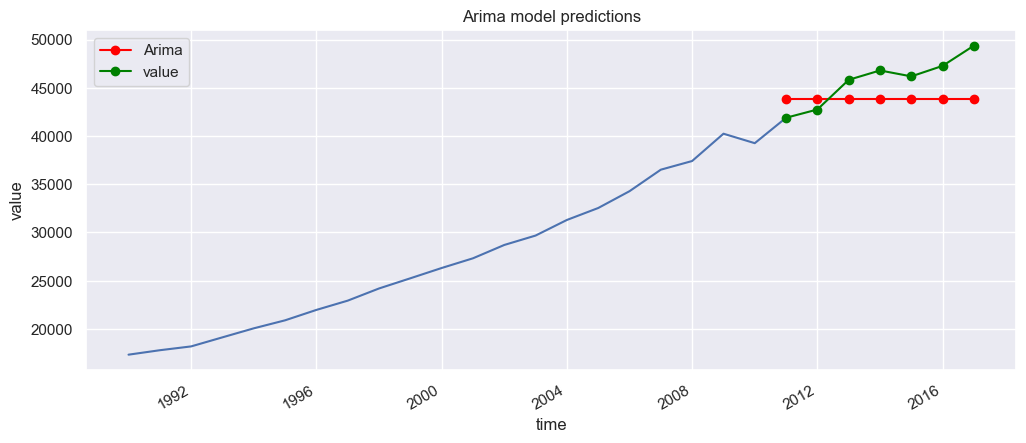

In [34]:
#run the ARIMA model with random numbers
model_arima = ARIMA(au2, order=(0,2,3))
model_arima_fit = model_arima.fit()
#save arima preds

#pass the same index as others
fcast1 = model_arima_fit.forecast(7)[0]
fcast1 = pd.Series(fcast1, index=index_7_years)
fcast1 = fcast1.rename('Arima')
fcast1 = fcast1.dropna()

#plot the predictions
plt.figure(figsize=(12,5), dpi=100)
chart = sns.lineplot(x='time', y='value', data=au)
chart.set_title('Arima model predictions')
fcast1.plot(ax=chart, color='red', marker='o', legend=True)
au_v2.plot(ax=chart, color='green', marker='o', legend=True)
#print the AI
print('AIC: ', model_arima_fit.aic)
#MSE
print('MSE of ARIMA is: ', mean_squared_error(au_v['value'].values, fcast1.values, squared=False))

In [32]:
##### option 1: finding the best value for ARIMA
p=d=q=range(0,5)
pdq=list(itertools.product(p,d,q))

for param in pdq:
    try:
        model_arima=ARIMA(au2,order=param)
        model_arima_fit=model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue
    

(0, 0, 0) 460.08750540507083
(0, 0, 1) 439.3242495933218
(0, 0, 2) 424.30816376991726
(0, 0, 3) 414.83137523381686
(0, 0, 4) 402.11500699342287
(0, 1, 0) 366.03093797679355
(0, 1, 1) 366.9611564835079
(0, 1, 2) 365.36317736867176
(0, 1, 3) 365.27571782000854
(0, 1, 4) 365.40554606803533
(0, 2, 0) 346.26068551893104
(0, 2, 1) 343.3425870556686
(0, 2, 2) 345.0085636022446
(0, 2, 3) 346.5492840969433
(0, 2, 4) 348.35519719212823
(0, 3, 0) 351.31564185706696
(0, 3, 1) 335.15808828533056
(0, 3, 2) 330.5278405833901
(0, 3, 3) 331.74256148712044
(0, 3, 4) 333.0201989593068
(0, 4, 0) 352.53386896429157
(0, 4, 1) 337.3604000335904
(0, 4, 2) 324.15682730262705
(0, 4, 3) 322.99891374413596
(0, 4, 4) 321.05683107104846
(1, 0, 0) 391.6058891433063
(1, 0, 1) 391.090294203307
(1, 0, 2) 374.42284664401126
(1, 0, 3) 375.95853164014045
(1, 0, 4) 366.1835026207996
(1, 1, 0) 366.0472592833245
(1, 1, 1) 346.8357415956367
(1, 1, 2) 344.81014525846433
(1, 1, 3) 346.8035881929803
(1, 1, 4) 353.48145015290834


<Axes: title={'center': 'Auto-ARIMA Forecast'}, xlabel='time', ylabel='value'>

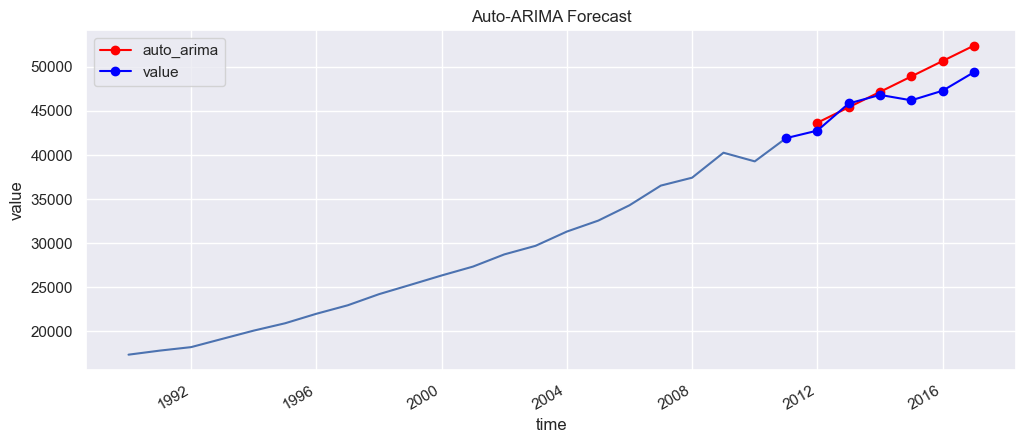

In [48]:
##### option 2: Auto-ARIMA
# replace NaN values with the mean of the non-NaN values
au2.fillna(au2.mean(), inplace=True)

auto_arima_model = pm.auto_arima(au2, seasonal=False, m=7, suppress_warnings=True)

#make forecasts
fcast2 = auto_arima_model.predict(n_periods=len(au2))
fcast2 = pd.Series(fcast2, index=index_7_years)
fcast2 = fcast2.rename('auto_arima')
fcast2 = fcast2.dropna()

#plot forecasts predictions
fig, ax = plt.subplots(figsize=(12, 5))
chart = sns.lineplot(x='time',y='value', data=au)
chart.set_title('Auto-ARIMA Forecast')
fcast2.plot(ax=ax, color='red', marker='o', legend=True)
au_v2.plot(ax=ax, color='blue', marker='o', legend=True)
#print rmse
#print('RMSE: ', np.sqrt(mean_squared_error(au_v['value'].values, fcast2.values, squared=False)))


#### Prophet
* [Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.
* Prophet works best with time series that have strong seasonal effects and several seasons of historical data. For more information on how Prophet works, see the [methodology page](https://facebook.github.io/prophet/docs/quick_start.html#python-api) on the Prophet website.

22:58:59 - cmdstanpy - INFO - Chain [1] start processing
22:59:01 - cmdstanpy - INFO - Chain [1] done processing


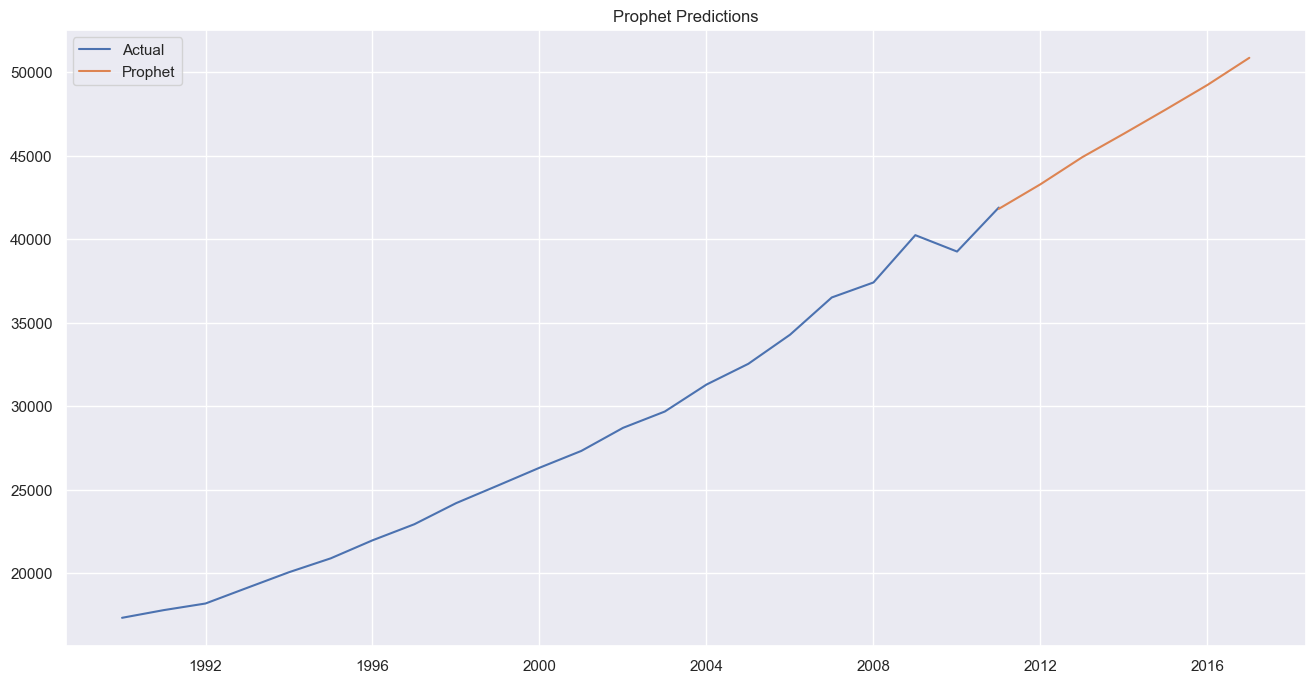

In [49]:
#copy and prepare expected column names
au3 = au.copy()
au3 = au3[['time', 'value']]
au3.columns = ['ds', 'y']
au3['ds'] = pd.to_datetime(au3['ds'])

#define the model
m3 = Prophet()
m3.fit(au3)
#define the period for which we want a prediction
df_index_7_years = pd.DataFrame(index_7_years)
df_index_7_years.columns = ['ds']
df_index_7_years['ds'] = pd.to_datetime(df_index_7_years['ds'])

#predict
fcast3 = m3.predict(df_index_7_years)
fcast3 = pd.Series(fcast3['yhat'].values, index=index_7_years)
fcast3 = fcast3.rename('Prophet')

#plotting the prediction
plt.figure(figsize=(16,8))
plt.plot(au3['ds'], au3['y'], label='Actual')
plt.plot(fcast3, label='Prophet')
plt.legend(loc='best')
plt.title('Prophet Predictions')
plt.show()



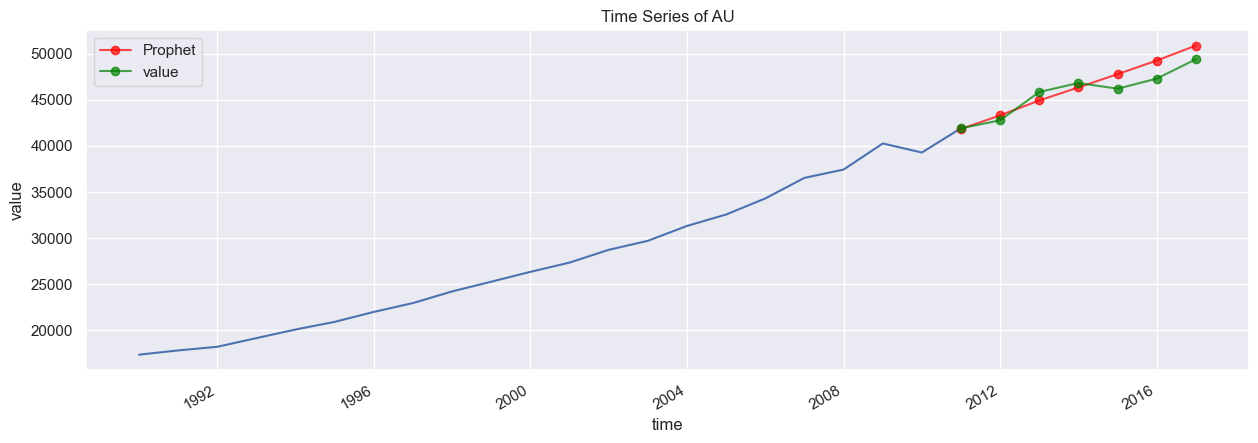

In [50]:
fig, ax = plt.subplots(figsize=(15,5))
chart = sns.lineplot(x='time', y='value', data=au)
chart.set_title('Time Series of AU')
fcast3.plot(ax=ax, color='red', marker='o', alpha=0.7, legend=True)
au_v2.plot(ax=ax, color='green', marker='o', alpha=0.7, legend=True)
plt.show()

In [51]:
m3.predict(df_index_7_years)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-01,27484.498353,41305.337899,42348.449177,27484.498353,27484.498353,14331.527730,14331.527730,14331.527730,14331.527730,14331.527730,14331.527730,0.0,0.0,0.0,41816.026083
1,2012-01-01,28970.147890,42756.399345,43883.053021,28941.785807,29001.056888,14319.218442,14319.218442,14319.218442,14319.218442,14319.218442,14319.218442,0.0,0.0,0.0,43289.366332
2,2013-01-01,30459.867700,44361.639530,45490.606846,30372.463814,30560.454016,14452.612146,14452.612146,14452.612146,14452.612146,14452.612146,14452.612146,0.0,0.0,0.0,44912.479845
3,2014-01-01,31945.517237,45730.386025,46903.830732,31775.566870,32140.103377,14375.879700,14375.879700,14375.879700,14375.879700,14375.879700,14375.879700,0.0,0.0,0.0,46321.396937
4,2015-01-01,33431.166774,47142.769325,48415.133739,33167.035359,33738.912293,14331.527730,14331.527730,14331.527730,14331.527730,14331.527730,14331.527730,0.0,0.0,0.0,47762.694504
5,2016-01-01,34916.816311,48566.308040,49990.813138,34540.061125,35347.249542,14319.218442,14319.218442,14319.218442,14319.218442,14319.218442,14319.218442,0.0,0.0,0.0,49236.034752
6,2017-01-01,36406.536120,50101.705316,51623.924321,35896.514249,36963.258248,14452.612146,14452.612146,14452.612146,14452.612146,14452.612146,14452.612146,0.0,0.0,0.0,50859.148266


##### Running all time series models together

ARIMA failed
ARIMA future failed
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=149.661, Time=0.05 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=148.146, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=150.843, Time=0.11 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=149.328, Time=0.03 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=149.064, Time=0.03 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,1,0)[12] intercept   : AIC=150.111, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,1,0)[12]          
Total fit time: 0.735 seconds
Auto-ARIMA future failed


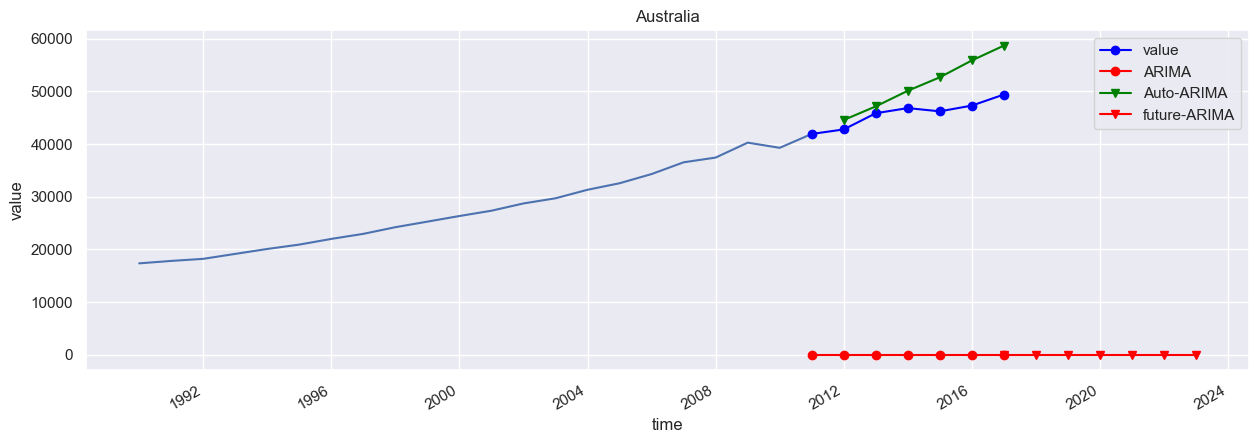

In [55]:
#step 1 - ARima & Auto ARima
#creating a country list
countries = forecast_data['country'].unique()
countries =['Australia']

#creating a list of dataframes
for c in countries:
    train_data = X_train[X_train['country']==c]
    train_data2 = train_data[['time', 'value']]

    valid_data = X_valid[X_valid['country']==c]
    valid_data2 = valid_data[['time', 'value']]

    all_data = forecast_data[forecast_data['country']==c]
    all_data2 = all_data[['time', 'value']]

    train_data2 = train_data2.set_index('time')
    valid_data2 = valid_data2.set_index('time')
    valid_data2 = valid_data2.rename(columns={'': 'Valid Data'})
    all_data2 = all_data2.set_index('time', inplace=True)
    

    #setting the valid data to the same index as the train data
    index_7_years = pd.date_range(train_data2.index[-1], periods=7, freq='AS')
    #setting the future data to the same index as the train data
    future_index_7_years = pd.date_range(valid_data2.index[-1], periods=7, freq='AS')

    #This is for the validation Phase
    try:
        try:
            #running ARIMA on Best parameters
            model_arima = ARIMA(train_data2, order=(0,2,3))
            model_arima_fit = model_arima.fit()
            predictions_arima = model_arima_fit.forecast(steps=7)[0]
            predictions_arima = pd.DataFrame(predictions_arima, index=index_7_years)
            predictions_arima.columns = ['ARIMA']
        except:
            #running ARIMA on default parameters
            model_arima = ARIMA(train_data2, order=(4,1,1))
            model_arima_fit = model_arima.fit()
            predictions_arima = model_arima_fit.forecast(steps=7)[0]
            predictions_arima = pd.DataFrame(predictions_arima, index=index_7_years)
            predictions_arima.columns = ['ARIMA']
    except:
        predictions_arima = pd.DataFrame(np.zeros(7), index=index_7_years)
        predictions_arima.columns = ['ARIMA']
        print('ARIMA failed')
    try:
        try:
            #this is for future phase
            #running ARIMA
            model_arima = ARIMA(all_data2, order=(0,2,3))
            model_arima_fit = model_arima.fit()
            predictions_arima_future = model_arima_fit.forecast(steps=7)[0]
            predictions_arima_future = pd.DataFrame(predictions_arima_future, index=future_index_7_years)
            predictions_arima_future.columns = ['future-ARIMA']
        except:
            #running ARIMA
            model_arima = ARIMA(all_data2, order=(4,1,0))
            model_arima_fit = model_arima.fit()
            predictions_arima_future = model_arima_fit.forecast(steps=7)[0]
            predictions_arima_future = pd.DataFrame(predictions_arima_future, index=future_index_7_years)
            predictions_arima_future.columns = ['future-ARIMA']
    except:
        predictions_arima_future = pd.DataFrame(np.zeros(7), index=future_index_7_years)
        predictions_arima_future.columns = ['future-ARIMA']
        print('ARIMA future failed')

        ### Auto-ARIMA
        #this is for validation phase
    try:
        try:
            #running auto-ARIMA on best parameters
            model_auto_arima = pm.auto_arima(train_data2, start_p=0, start_q=0, max_p=5, max_q=5, m=12, start_P=0, seasonal=True, d=2, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
            model_auto_arima.fit(train_data2)
            predictions_auto_arima = model_auto_arima.predict(n_periods=7)
            predictions_auto_arima = pd.DataFrame(predictions_auto_arima, index=index_7_years)
            predictions_auto_arima.columns = ['Auto-ARIMA']
        except:
            #running auto-ARIMA on default parameters
            model_auto_arima = pm.auto_arima(train_data2, start_p=0, start_q=0, max_p=5, max_q=5, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
            model_auto_arima.fit(train_data2)
            predictions_auto_arima = model_auto_arima.predict(n_periods=7)
            predictions_auto_arima = pd.DataFrame(predictions_auto_arima, index=index_7_years)
            predictions_auto_arima.columns = ['Auto-ARIMA']
    except:
        predictions_auto_arima = pd.DataFrame(np.zeros(7), index=index_7_years)
        predictions_auto_arima.columns = ['Auto-ARIMA']
        print('Auto-ARIMA failed')
    try:
        try:
            #this is for future phase
            #running auto-ARIMA on best parameters
            model_auto_arima = pm.auto_arima(all_data2, start_p=0, start_q=0, max_p=5, max_q=5, m=12, start_P=0, seasonal=True, d=2, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
            model_auto_arima.fit(all_data2)
            predictions_auto_arima_future = model_auto_arima.predict(n_periods=7)
            predictions_auto_arima_future = pd.DataFrame(predictions_auto_arima_future, index=future_index_7_years)
            predictions_auto_arima_future.columns = ['future-Auto-ARIMA']
        except:
            #running auto-ARIMA on default parameters
            model_auto_arima = pm.auto_arima(all_data2, start_p=0, start_q=0, max_p=5, max_q=5, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
            model_auto_arima.fit(all_data2)
            predictions_auto_arima_future = model_auto_arima.predict(n_periods=7)
            predictions_auto_arima_future = pd.DataFrame(predictions_auto_arima_future, index=future_index_7_years)
            predictions_auto_arima_future.columns = ['future-Auto-ARIMA']
    except:
        predictions_auto_arima_future = pd.DataFrame(np.zeros(7), index=future_index_7_years)
        predictions_auto_arima_future.columns = ['future-Auto-ARIMA']
        print('Auto-ARIMA future failed')

        #Plotting the results
    fig, ax = plt.subplots(figsize=(15, 5))
    chart = sns.lineplot(x='time', y='value', data= train_data)
    chart.set_title(c)
    valid_data2.plot(ax=ax, color='blue', marker='o',legend=True)
    #plotting validation phase
    try:
        predictions_arima.plot(ax=ax, color='red', marker='o',legend=True)
    except:
        print('ARIMA failed')
    try:
        predictions_auto_arima.plot(ax=ax, color='green', marker='v',legend=True)
    except:
        print('Auto-ARIMA failed')
    #plotting future phase
    try:
        predictions_arima_future.plot(ax=ax, color='red', marker='v',legend=True)
    except:
        print('ARIMA future failed')
